In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
img_size = 96

def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

In [3]:
Altered_path = "../input/socofing/SOCOFing/Altered/Altered-"
Real_path = "../input/socofing/SOCOFing/Real"

Easy_data = load_data(Altered_path+'Easy', train=True)
Medium_data = load_data(Altered_path+'Medium', train=True)
Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)

Altered_data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)
del Easy_data, Medium_data, Hard_data # Free some memory

Loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Medium
Loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Hard
Loading data from:  ../input/socofing/SOCOFing/Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
X_Altered, y_SubjectID_Altered, y_fingerNum_Altered = [], [], []

for SubjectID, fingerNum, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600) # 600 persons in total
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10) # 10 fingers per person

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

In [5]:
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

In [6]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("full SubjectID data:  ", X_Altered.shape, y_SubjectID_Altered.shape)
print("SubjectID_Train:      ", X_SubjectID_train.shape, y_SubjectID_train.shape)
print("SubjectID_Validation: ", X_SubjectID_val.shape, y_SubjectID_val.shape)
print("SubjectID_Test:       ", X_test.shape, y_SubjectID_test.shape)
print("----------------------------------------------------")
print("full fingerNum data:  ", X_Altered.shape, y_fingerNum_Altered.shape)
print("fingerNum_Train:      ", X_fingerNum_train.shape, y_fingerNum_train.shape)
print("fingerNum_Validation: ", X_fingerNum_val.shape, y_fingerNum_val.shape)
print("fingerNum_Test:       ", X_test.shape, y_fingerNum_test.shape)

del Altered_data, Real_data, y_SubjectID_Altered # Free some memory again

Shapes:                  Feature shape    label shape
----------------------------------------------------
full SubjectID data:   (49270, 96, 96, 1) (49270, 600)
SubjectID_Train:       (39416, 96, 96, 1) (39416, 600)
SubjectID_Validation:  (9854, 96, 96, 1) (9854, 600)
SubjectID_Test:        (6000, 96, 96, 1) (6000, 600)
----------------------------------------------------
full fingerNum data:   (49270, 96, 96, 1) (49270, 10)
fingerNum_Train:       (39416, 96, 96, 1) (39416, 10)
fingerNum_Validation:  (9854, 96, 96, 1) (9854, 10)
fingerNum_Test:        (6000, 96, 96, 1) (6000, 10)


In [7]:
nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

2022-04-20 13:30:56.943307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 13:30:57.060625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 13:30:57.061338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 13:30:57.063515: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "SubjectID_Mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 128)     

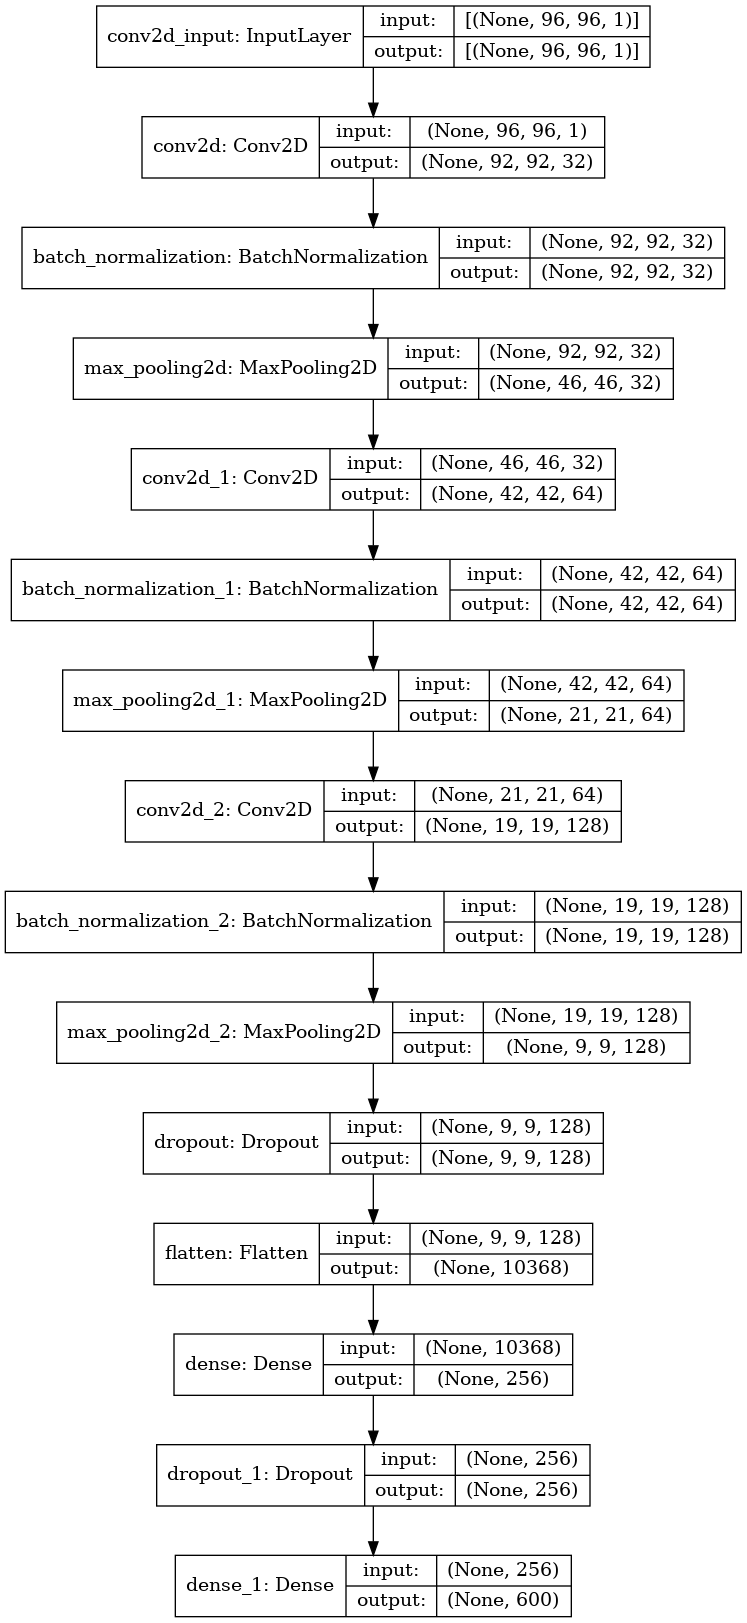

In [8]:
plot_model(model[0], show_shapes=True, to_file='./model0.png')

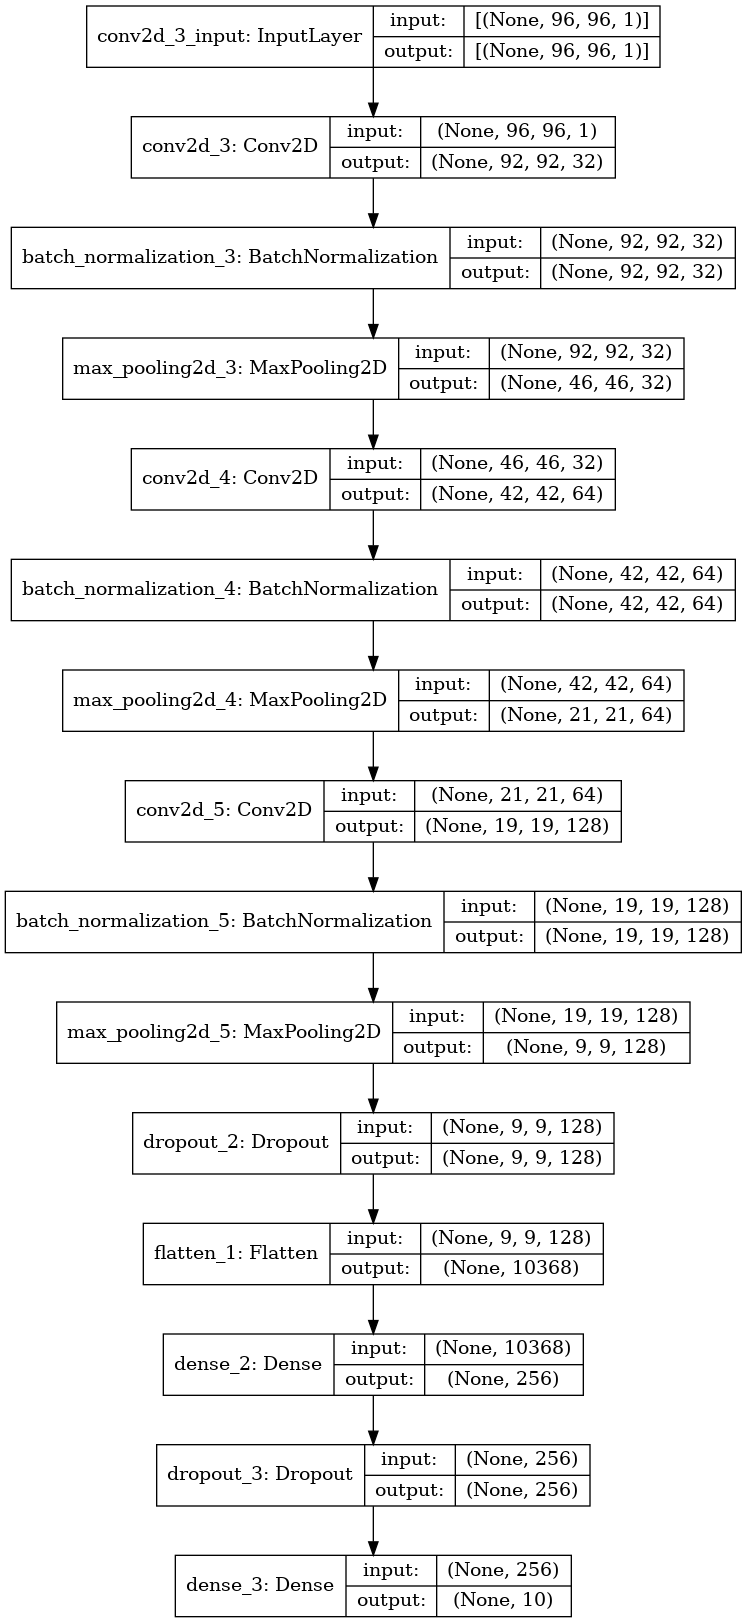

In [9]:
plot_model(model[1], show_shapes=True, to_file='./model1.png')

In [10]:
del X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val

In [11]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train, y_SubjectID_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1, callbacks= CallBack[0])

2022-04-20 13:31:01.227856: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-20 13:31:01.227900: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-20 13:31:01.231920: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-04-20 13:31:01.414235: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-20 13:31:01.414445: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-04-20 13:31:01.536448: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-20 13:31:01.536495: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-20 13:31:01.623517: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-20 13:31:01.623699: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPT

Epoch 1/20


2022-04-20 13:31:06.644251: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/616 [..............................] - ETA: 1:14:24 - loss: 7.4916 - accuracy: 0.0000e+00

2022-04-20 13:31:12.435705: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-20 13:31:12.435749: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/616 [..............................] - ETA: 3:19 - loss: 7.5613 - accuracy: 0.0000e+00   

2022-04-20 13:31:12.742722: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-20 13:31:12.743970: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-04-20 13:31:12.876883: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 210 callback api events and 207 activity events. 
2022-04-20 13:31:12.885363: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-20 13:31:12.905050: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./log_dir/SubjectID_Mod/train/plugins/profile/2022_04_20_13_31_12

2022-04-20 13:31:12.911110: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./log_dir/SubjectID_Mod/train/plugins/profile/2022_04_20_13_31_12/3b4174149df9.trace.json.gz
2022-04-20 13:31:12.935141: I tensorflow/core/profiler/rpc/client/save_profile.cc:13

616/616 [==============================] - ETA: 0s - loss: 6.5176 - accuracy: 0.0034

2022-04-20 13:31:22.916452: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 363257856 exceeds 10% of free system memory.


616/616 [==============================] - 20s 21ms/step - loss: 6.5176 - accuracy: 0.0034 - val_loss: 6.3652 - val_accuracy: 0.0073
Epoch 2/20
616/616 [==============================] - 11s 17ms/step - loss: 6.1319 - accuracy: 0.0172 - val_loss: 5.6307 - val_accuracy: 0.0613
Epoch 3/20
616/616 [==============================] - 10s 17ms/step - loss: 5.1784 - accuracy: 0.0882 - val_loss: 4.2433 - val_accuracy: 0.2669
Epoch 4/20
616/616 [==============================] - 10s 17ms/step - loss: 3.6697 - accuracy: 0.2746 - val_loss: 2.5632 - val_accuracy: 0.6296
Epoch 5/20
616/616 [==============================] - 10s 17ms/step - loss: 2.2603 - accuracy: 0.5244 - val_loss: 1.2396 - val_accuracy: 0.8341
Epoch 6/20
616/616 [==============================] - 10s 17ms/step - loss: 1.3445 - accuracy: 0.7156 - val_loss: 0.7130 - val_accuracy: 0.9274
Epoch 7/20
616/616 [==============================] - 11s 17ms/step - loss: 0.8690 - accuracy: 0.8227 - val_loss: 0.4737 - val_accuracy: 0.9510
Epo

In [12]:
# Delete the SubjectID dataset after it was used
del X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val
# Then reload fingerNum dataset before model fitting
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

del X_Altered, y_fingerNum_Altered

history[1] = model[1].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/20
  1/616 [..............................] - ETA: 9:43 - loss: 5.9452 - accuracy: 0.0469

2022-04-20 13:35:32.811013: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-20 13:35:32.811064: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/616 [..............................] - ETA: 2:39 - loss: 4.7509 - accuracy: 0.1354

2022-04-20 13:35:33.123524: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-20 13:35:33.123994: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-04-20 13:35:33.253872: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 207 callback api events and 204 activity events. 
2022-04-20 13:35:33.260071: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-20 13:35:33.266608: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./log_dir/FingerNum_Mod/train/plugins/profile/2022_04_20_13_35_33

2022-04-20 13:35:33.271216: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./log_dir/FingerNum_Mod/train/plugins/profile/2022_04_20_13_35_33/3b4174149df9.trace.json.gz
2022-04-20 13:35:33.281021: I tensorflow/core/profiler/rpc/client/save_profile.cc:13

616/616 [==============================] - 13s 19ms/step - loss: 1.7679 - accuracy: 0.4258 - val_loss: 1.3138 - val_accuracy: 0.5812
Epoch 2/20
616/616 [==============================] - 10s 17ms/step - loss: 1.2121 - accuracy: 0.6130 - val_loss: 0.9342 - val_accuracy: 0.7211
Epoch 3/20
616/616 [==============================] - 10s 17ms/step - loss: 0.9051 - accuracy: 0.7201 - val_loss: 0.7093 - val_accuracy: 0.8029
Epoch 4/20
616/616 [==============================] - 10s 17ms/step - loss: 0.6623 - accuracy: 0.8090 - val_loss: 0.4941 - val_accuracy: 0.8802
Epoch 5/20
616/616 [==============================] - 10s 16ms/step - loss: 0.4855 - accuracy: 0.8744 - val_loss: 0.3579 - val_accuracy: 0.9292
Epoch 6/20
616/616 [==============================] - 10s 16ms/step - loss: 0.3733 - accuracy: 0.9144 - val_loss: 0.2802 - val_accuracy: 0.9568
Epoch 7/20
616/616 [==============================] - 10s 17ms/step - loss: 0.3091 - accuracy: 0.9369 - val_loss: 0.2694 - val_accuracy: 0.9602
Epo

In [13]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Launch TensorBoard
# Supervising the SubjectID model
%tensorboard --logdir './log_dir/SubjectID_log'
# or, supervising the fingerNum model
# %tensorboard --logdir './log_dir/fingerNum_log'

Id recognition accuracy:  99.73333477973938 %
Finger recognition accuracy:  99.90000128746033 %


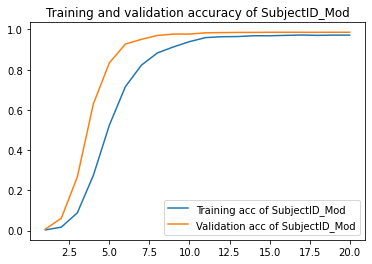

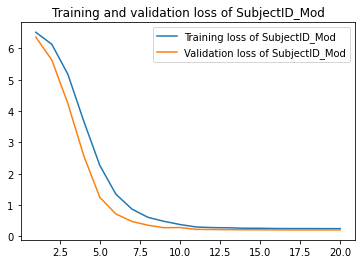

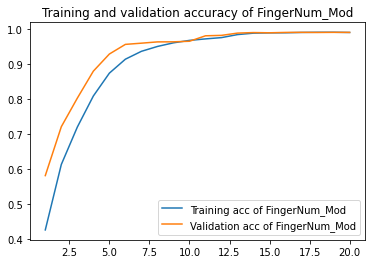

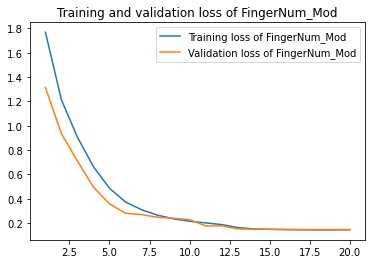

In [14]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

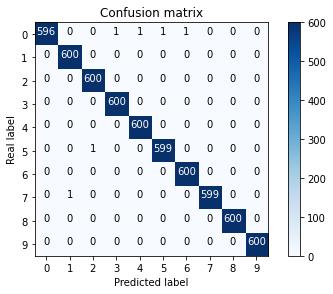

In [15]:
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Infomation confirm! Fingerprint matches: person Id 540 right ring


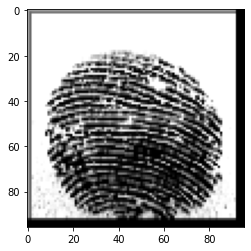

In [16]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred==Id_real and fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred, show_fingername(fingerNum_pred))
else:
    print("Oops! Prediction is wrong!")